# 图像边缘增强（Canny算子）

## 必要python库的导入

In [37]:
from PIL import Image as im
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

## 读取图片，图片预处理阶段

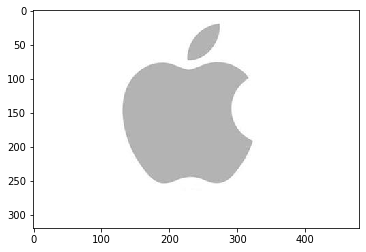

In [38]:
image1 = im.open('Apple.jpg')
plt.imshow(image1)
plt.show()
im_gray_1 = image1.convert('L')
im_array_1 = np.array(im_gray_1)

## step 1 用高斯滤波器平滑图像

In [39]:
def createGaussian_kernel(N,sigma):
    Gaussian_kernel = np.zeros((N,N))
    center = (N + 1) / 2 
    for i in range(N):
        for j in range(N):
            Gaussian_kernel[i,j] = math.exp((-(i-center)*(i-center)-(j-center)*(j-center))/(2*sigma*sigma))/(2*3.14*sigma*sigma)
    Gaussian_kernel = Gaussian_kernel / sum(sum(Gaussian_kernel))
    return Gaussian_kernel

In [40]:
Gaussian_kernel = createGaussian_kernel(5,1)
im1_Gaussian = cv2.filter2D(im_array_1,-1,Gaussian_kernel)
im1_show = np.uint8(im1_Gaussian)
im1_show = im.fromarray(im1_show)
im1_show.show()

## step 2 用一阶偏导的有限差分来计算梯度的复制

In [41]:
def difference(I):
    (height,width) = I.shape
    dx = np.zeros((height,width))
    dy = np.zeros((height,width))
    d = np.zeros((height,width))
    for i in range(1,height-1):
        for j in range(1,width-1):
            dx[i,j] = I[i,j+1] - I[i,j]
            dy[i,j] = I[i+1,j] - I[i,j]
            d[i,j] = math.sqrt(dx[i,j] * dx[i,j] + dy[i,j] * dy[i,j]) 
    return dx,dy,d

## step 3 对梯度幅值进行非极大值抑制

In [42]:
dx1,dy1,d1 = difference(im1_Gaussian)
d1_show = np.uint8(d1)
d1_show = im.fromarray(d1_show)
d1_show.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ubyte_scalars
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ubyte_scalars
  


In [43]:
def restrain(dx,dy,d):
    (height,width) = d.shape
    d_pro = d
    d_pro[1,:] = 0
    d_pro[-1,:] = 0
    d_pro[:,1] = 0
    d_pro[:,-1] = 0
    #print(d_pro[2,6])
    for i in range(2,height):
        for j in range(2,width):
            if d[i,j] == 0:
                d_pro[i,j] = 0;#梯度值为零的点一定不是边缘点
            else:
                x_grad = dx[i,j]
                y_grad = dy[i,j]
                grad = d[i,j]
                if abs(y_grad) > abs(x_grad):
                    weight = abs(x_grad / y_grad)
                    grad_2 = d[i-1,j]
                    grad_4 = d[i+1,j]
                    if x_grad * y_grad > 0:
                        grad_1 = d[i-1,j-1]
                        grad_3 = d[i-1,j+1]
                    else:
                        grad_1 = d[i-1,j+1]
                        grad_3 = d[i+1,j-1]
                else:
                    weight = abs(x_grad / y_grad)  
                    grad_2 = d[i,j - 1]
                    grad_4 = d[i,j + 1]
                    if x_grad * y_grad > 0:
                        grad_1 = d[i + 1,j + 1]  
                        grad_3 = d[i - 1,j - 1] 
                    else:  
                        grad_1 = d[i - 1,j + 1] 
                        grad_3 = d[i + 1,j - 1] 
                grad_inter1 = weight * grad_1 + (1 - weight) * grad_2
                grad_inter2 = weight * grad_3 + (1 - weight) * grad_4
                if grad >= grad_inter1 and grad >= grad_inter2:
                    d_pro[i,j] = grad
                else:
                    #print(d_pro)
                    d_pro[i,j] = 0
    #d_pro = d_pro / d_pro.max()
    return d_pro

In [44]:
d_pro1 = restrain(dx1,dy1,d1)
d_pro1_show = np.uint8(d_pro1)
d_pro1_show = im.fromarray(d_pro1_show)
d_pro1_show.show()
d_pro1 = d_pro1 / d_pro1.max()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


## 双阈值化

In [45]:
def doublethreshold(d_pro,threshold_high,threshold_low):
    (height,width) = d_pro.shape
    edge_real = np.zeros((height,width))  
    edge_possible = np.zeros((height,width))
    for i in range(1,height):
        for j in range(1,width):
            if d_pro[i,j] >= threshold_high:
                edge_real[i,j] = d_pro[i,j]  
            elif d_pro[i,j] >= threshold_low : 
                edge_possible[i,j] = d_pro[i,j]; 
    return edge_real,edge_possible

In [46]:
def createfinalimage(edge_real,edge_possible):
    (height,width) = edge_real.shape
    pos_1 = 0
    pos_2 = 0
    temp_matrix = np.zeros((10000000,2))
    edge = np.zeros((height,width))
    for i in range(1,height): 
        for j in range(1,width):
            if edge_real[i,j] > 0: 
                temp_matrix[pos_2,0] = i;  
                temp_matrix[pos_2,1] = j;  
                pos_2 = pos_2 + 1;  
                edge[i,j] = 1;
                edge_real[i,j] = 0
        while pos_1 != pos_2:
            temp_i = temp_matrix[pos_1,0];  
            temp_j = temp_matrix[pos_1,1];  
            pos_1 = pos_1 + 1; 
            for p in [-1,0,1]:
                for q in [-1,0,1]:
                    x = int(temp_i + p)
                    y = int(temp_j + q)
                    #print(edge_possible)
                    if edge_possible[x,y] > 0:
                        edge_real[x,y] = 1  
                        edge_possible[x,y] = 0 
                        temp_matrix[pos_2,0] = x  
                        temp_matrix[pos_2,1] = y  
                        pos_2 = pos_2 + 1;  
    return edge

In [47]:
edge1_real,edge1_possible = doublethreshold(d_pro1,0.3,0.1)
print(edge1_possible[50,50])
edge1 = createfinalimage(edge1_real,edge1_possible)
edge1 = 255 * edge1
edge1_show = np.uint8(edge1)
edge1_show = im.fromarray(edge1_show)
edge1_show.show()

0.0


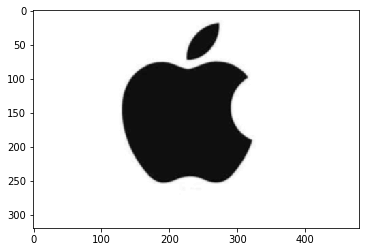

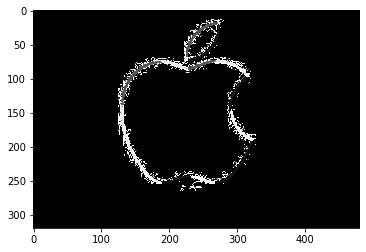

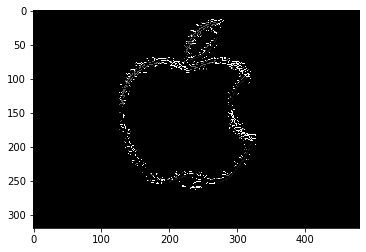

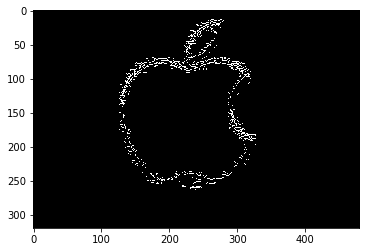

In [48]:
plt.imshow(im1_show,cmap='gray')
plt.show()
plt.imshow(d1_show,cmap='gray')
plt.show()
plt.imshow(d_pro1_show,cmap='gray')
plt.show()
plt.imshow(edge1_show,cmap='gray')
plt.show()

# 小图显示效果较差！！！请看运行中弹出的大图！！！！！